#### Train a single network for 3 MNIST tasks sequentially

In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm_notebook

/home/rs3871/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

#### The classifier model is defined in model.py

In [4]:
# import class Model from model.py
from model import Model

#### In the next cell we read the mnist data and create placeholders for input to GAN and also define leaky relu function and binary cross entropy function

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)
tf.reset_default_graph()
batch_size = 100
n_noise = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### In the Next cell we define ta function to show the images in a grid

In [6]:

def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

#### Now we define the Discriminator network

In [7]:
def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

#### The next cell define the Scholar generator

In [8]:
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x    

#### Defining the Old scholar (Generator 2) network

In [9]:
def generator1(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator1", reuse=tf.AUTO_REUSE):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x   

#### We create the computation graph and initialize the variables

In [10]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]

vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
g1 = generator1(noise, keep_prob, is_training)
saver = tf.train.Saver(tf.global_variables())
#sess = tf.Session()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

####  create placeholders for input to the classifier

In [11]:
# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

#### instantiate new model

In [12]:
model = Model(x, y_) # our classifier which needs to learn all the tasks

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



#### Initialize all variables

In [13]:
# initialize variables
sess.run(tf.global_variables_initializer())

####  return a new mnist dataset with pixels randomly permuted

In [14]:

def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')


def permute_mnist(mnist):
    perm_inds = np.arange(mnist.train.images.shape[1])
    np.random.shuffle(perm_inds)
    
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) 
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2


#### Definiton of the GAN training function- The GAN is trained for 15000n iterations which wiil take 40 mins in k80 GPU 
#### To speed up, put thee pre trained model files in the './tmp' directory

In [15]:
def train_gan(data,mem):
    for i in tqdm_notebook(range(15000)):
        train_d = True
        train_g = True
        keep_prob_train = 0.6

       
        
        batch = [np.reshape(b, [28, 28]) for b in data.train.next_batch(batch_size=batch_size)[0]]  
        n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32) 
        if(mem):
            fake_prev=sess.run(g1,feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
            fake_prev=np.squeeze(fake_prev)
            batch = [np.reshape(b, [28, 28]) for b in data.train.next_batch(batch_size=batch_size)[0]]  
            batch=np.append(batch[0:50],fake_prev[50:100],axis=0)
        
        d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})

        d_real_ls = np.mean(d_real_ls)
        d_fake_ls = np.mean(d_fake_ls)
        g_ls = g_ls
        d_ls = d_ls

        if g_ls * 1.5 < d_ls:
            train_g = False
            pass
        if d_ls * 2 < g_ls:
            train_d = False
            pass

        if train_d:
            sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})


        if train_g:
            sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})


        if not i % 1000:
            print (i, d_ls, g_ls, d_real_ls, d_fake_ls)
            if not train_g:
                print("not training generator")
            if not train_d:
                print("not training discriminator")
            gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
            imgs = [img[:,:,0] for img in gen_img]
            m = montage(imgs)
            gen_img = m
            plt.axis('off')
            plt.imshow(gen_img, cmap='gray')
            plt.show()
    
    vars_g1 = [var for var in tf.trainable_variables() if var.name.startswith("generator1")]
    glob_g=[var for var in tf.global_variables() if var.name.startswith("generator")]
    glob_g1= [var for var in tf.global_variables() if var.name.startswith("generator1")]

    for i in range(len(vars_g)):
        sess.run(vars_g1[i].assign(vars_g[i].eval(sess)))
    
    for i in range(len(glob_g1)):
        sess.run(glob_g1[i].assign(glob_g[i].eval(sess)))

#### Definintion of Training function for classifier which trains the classifieer on easch taskk with EWC + Generative replay 

In [16]:

def plot_test_acc(plot_handles):
    plt.figure(0,figsize=(5,5))
    plt.legend(handles=plot_handles,loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    

def train_task(g,g1,batch_size,n_noise,model, num_iter, disp_freq, trainset, testsets, x, y_, lams=[0]):
    keep_prob_train = 1
    best_accu=[]
    for l in range(len(lams)):
        
        model.restore(sess) 
        if(lams[l] == 0):
            n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)
            model.set_vanilla_loss()
        else:
            
            model.update_ewc_loss(lams[l])
            n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)
            prev_data=sess.run(g,feed_dict={noise: n, keep_prob: keep_prob_train, is_training:False})
            prev_data=np.reshape(prev_data,[100,784])
       
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
       
        for iter in range(num_iter):
            if(lams[l] == 0):
                batch = trainset.train.next_batch(100)
                batch1=batch[0]
                batch2=batch[1]
            else:
                batch = trainset.train.next_batch(100)
                prev_labels=sess.run(model.y,feed_dict={x: prev_data[0:50], y_: batch[1]})
                
                
                prev_labels1=np.argmax(prev_labels,axis=1)
                prev_labels2=np.zeros([50,10])
                prev_labels2[np.arange(50), prev_labels1] = 1
                
                
                batch1=np.append(batch[0][0:50],prev_data[0:50],axis=0)
                batch2=np.append(batch[1][0:50],prev_labels2,axis=0)
                
                
            model.train_step.run(feed_dict={x: batch1, y_: batch2})
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                
                plot_test_acc(plots)
                
                
                if l == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc + generative memory")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
        for task in range(len(testsets)):
            best_accu.append(test_accs[task][89])
                
    if len(testsets)==1:
        if(tf.train.checkpoint_exists("./tmp/model1.ckpt")):
            print('loading saved model..')
            saver.restore(sess, "./tmp/model1.ckpt")
            print('Images generated by the pretrained Generative memory for task 1')
            gen_img=sess.run(g,feed_dict={noise: n, keep_prob:1.0, is_training:False})
            imgs = [img[:,:,0] for img in gen_img]
            m = montage(imgs)
            gen_img = m
            plt.figure(1,figsize=(8, 8))
            plt.title('Images generated by the pretrained Generative memory for task 1')
            plt.axis('off')
            plt.imshow(gen_img, cmap='gray')
            plt.show()
            
        else:
            print('no saved model available. Download saved model from bitbucket and put it in ./tmp/ directory for faster inference ')
            print('training generative memory for 15000 iterations, this will take about 40 mins in K80 gpu' )
            
            train_gan(trainset,False)
            
    if len(testsets)==2:
        if(tf.train.checkpoint_exists("./tmp/model2.ckpt")):
            print('loading saved model..')
            saver.restore(sess, "./tmp/model2.ckpt")
            print('Images generated by the pretrained Generative memory for task 1 and 2 combined')
            gen_img=sess.run(g,feed_dict={noise: n, keep_prob:1.0, is_training:False})
            imgs = [img[:,:,0] for img in gen_img]
            m = montage(imgs)
            gen_img = m
            plt.figure(1,figsize=(8, 8))
            plt.title('Images generated by the pretrained Generative memory for task 1 and 2 combined')
            plt.axis('off')
            plt.imshow(gen_img, cmap='gray')
            plt.show()
        else:
            print('no saved model available. Download saved model from bitbucket and put it in ./tmp/ directory for faster inference ')
            print('training generative memory for 15000 iterations, this will take about 40 mins in K80 gpu' )
            train_gan(trainset,True)
    
    if len(testsets)==3:
        if(tf.train.checkpoint_exists("./tmp/model3.ckpt")):
            print('loading saved model..')
            saver.restore(sess, "./tmp/model3.ckpt")
            print('Images generated by the pretrained Generative memory for task 1, 2 and 3 combined')
            gen_img=sess.run(g,feed_dict={noise: n, keep_prob:1.0, is_training:False})
            imgs = [img[:,:,0] for img in gen_img]
            m = montage(imgs)
            plt.figure(1,figsize=(8, 8))
            plt.title('Images generated by the pretrained Generative memory for task 1, 2 and 3 combined')
            gen_img = m
            plt.axis('off')
            plt.imshow(gen_img, cmap='gray')
            plt.show()
            
        else:
            print('no saved model available. Download saved model from bitbucket and put it in ./tmp/ directory for faster inference ')
            print('training generative memory for 15000 iterations, this will take about 40 mins in K80 gpu' )
            train_gan(trainset,True)
    return best_accu

#### training of task A and the trained classifier is tested on the test data for Task A

loading saved model..
INFO:tensorflow:Restoring parameters from ./tmp/model1.ckpt
Images generated by the pretrained Generative memory for task 1


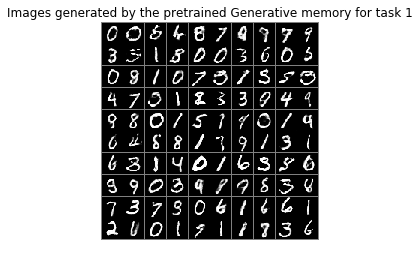

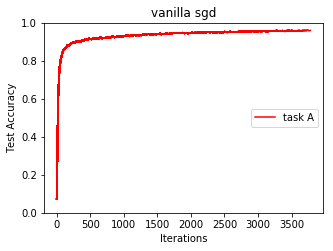

accuracy at the end of training for task- 0 with vanilla sgd: 0.9453999996185303


In [17]:
# training 1st task
best_accu=train_task(g,g1,batch_size,n_noise,model, 3800, 20, mnist, [mnist], x, y_, lams=[0])
for i in range(len(best_accu)):
    print('accuracy at the end of training for task- '+str(i)+' with vanilla sgd:',best_accu[i])

#### Uncomment the below cell if you want to save the models trained for Task A

In [18]:
'''
saver = tf.train.Saver(tf.global_variables())
save_path = saver.save(sess, "./tmp/model1.ckpt")
'''

'\nsaver = tf.train.Saver(tf.global_variables())\nsave_path = saver.save(sess, "./tmp/model1.ckpt")\n'

#### Fisher information Computation using the validation set of Task A

In [19]:
model.compute_fisher(mnist.validation.images, sess, num_samples=200) 

#### visualizing row wise mean fisher of W!

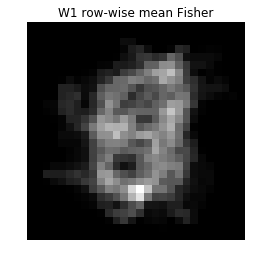

In [20]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

#### Permuting the pixels in MNIST dataset to create a new dataset for Task B

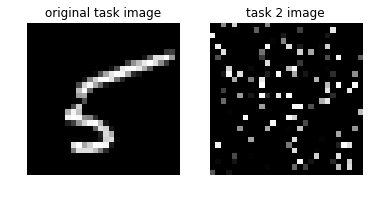

In [21]:

mnist2 = permute_mnist(mnist)

plt.subplot(1,2,1)
mnist_imshow(mnist.train.images[4])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[4])
plt.title("task 2 image");


#### save current optimal weights for the tasks the classifier has been trained on till now

In [22]:

model.star()

#### training of task B and the trained classifier is tested on the test data for Task A and Task B

loading saved model..
INFO:tensorflow:Restoring parameters from ./tmp/model2.ckpt
Images generated by the pretrained Generative memory for task 1 and 2 combined


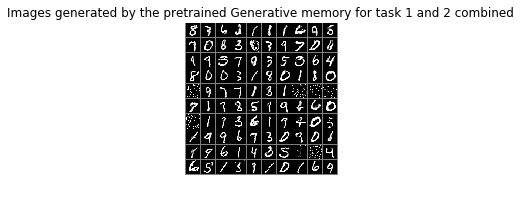

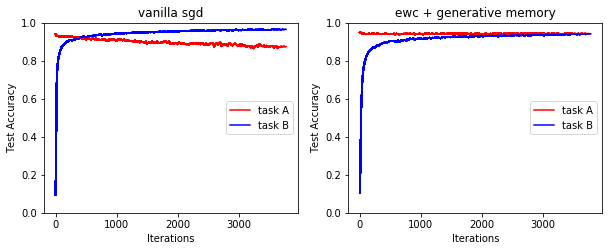

task- 0accuracy at the end of training for task 2 with vanilla sgd: 0.9041000008583069
task- 1accuracy at the end of training for task 2 with vanilla sgd: 0.9527000188827515
task- 0accuracy at the end of training for task 2 with Generative memory: 0.9398000240325928
task- 1accuracy at the end of training for task 2 with Generative memory: 0.9221000075340271


In [23]:
# training 2nd task
best_accu=train_task(g,g1,batch_size,n_noise,model, 3800, 20, mnist2, [mnist, mnist2], x, y_, lams=[0,15])
for i in range(len(best_accu)):
    if(i<2):
        print('task- '+str(i)+'accuracy at the end of training for task 2 with vanilla sgd:',best_accu[i])
    else:
        print('task- '+str(i-2)+'accuracy at the end of training for task 2 with Generative memory:',best_accu[i])

#### Uncomment the below cell if you want to save the models trained for Task A

In [24]:
'''
saver = tf.train.Saver(tf.global_variables())
save_path = saver.save(sess, "./tmp/model2.ckpt")
'''

'\nsaver = tf.train.Saver(tf.global_variables())\nsave_path = saver.save(sess, "./tmp/model2.ckpt")\n'

#### Fisher information Computation using the validation set of Task B

In [26]:

model.compute_fisher(mnist2.validation.images, sess, num_samples=200)

#### visualizing row wise mean fisher of W1 after training on Task B

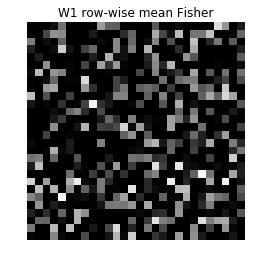

In [27]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

#### Permuting the pixels in MNIST dataset to create a new dataset for Task C

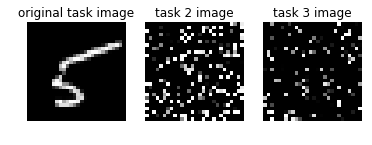

In [28]:

mnist3 = permute_mnist(mnist)
plt.subplot(1,3,1)
mnist_imshow(mnist.train.images[4])
plt.title("original task image")
plt.subplot(1,3,2)
mnist_imshow(mnist2.train.images[4])
plt.title("task 2 image");
plt.subplot(1,3,3)
mnist_imshow(mnist3.train.images[4])
plt.title("task 3 image");

#### save current optimal weights for the tasks the classifier has been trained on till now

In [29]:
# save current optimal weights
model.star()

#### training of task C and the trained classifier is tested on the test data for Task A, Task B and Task C

loading saved model..
INFO:tensorflow:Restoring parameters from ./tmp/model3.ckpt
Images generated by the pretrained Generative memory for task 1, 2 and 3 combined


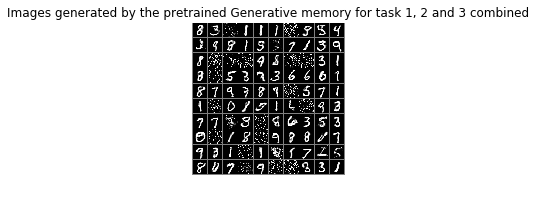

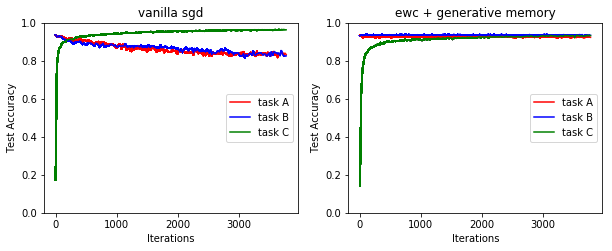

task- 0accuracy at the end of training for task 2 with vanilla sgd: 0.8432000279426575
task- 1accuracy at the end of training for task 2 with vanilla sgd: 0.8701000213623047
task- 2accuracy at the end of training for task 2 with vanilla sgd: 0.9506000280380249
task- 0accuracy at the end of training for task 2 with Generative memory: 0.923799991607666
task- 1accuracy at the end of training for task 2 with Generative memory: 0.9341999888420105
task- 2accuracy at the end of training for task 2 with Generative memory: 0.9204000234603882


In [30]:
# training 3rd task
best_accu=train_task(g,g1,batch_size,n_noise,model, 3800, 20, mnist3, [mnist, mnist2, mnist3], x, y_, lams=[0, 15])
for i in range(len(best_accu)):
    if(i<3):
        print('task- '+str(i)+'accuracy at the end of training for task 3 with vanilla sgd:',best_accu[i])
    else:
        print('task- '+str(i-3)+'accuracy at the end of training for task 3 with Generative memory:',best_accu[i])

#### Uncomment the below cell if you want to save the models trained for Task A

In [ ]:
'''
saver = tf.train.Saver(tf.global_variables())
save_path = saver.save(sess, "./tmp/model3.ckpt")
'''